In [2]:
from datasets import Dataset, load_dataset, load_from_disk
# dataset = load_dataset("sem_eval_2018_task_1", "subtask5.english")

dataset = load_dataset("../dataset/sem_eval_2018_task_1", "subtask5.english")


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 13676
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 1772
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6518
    })
})

In [4]:
dataset['train'][0]

{'ID': '2017-En-21441',
 'Tweet': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'anger': False,
 'anticipation': True,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': True}

数据集由tweet组成，标记为一种或多种情绪。

In [5]:
labels = [label for label in dataset['train'].features.keys() if label not in ['ID', 'Tweet']]
id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}


labels

In [6]:
from transformers import AutoTokenizer
import numpy as np


model_path = r"D:\code\personal\models\bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)


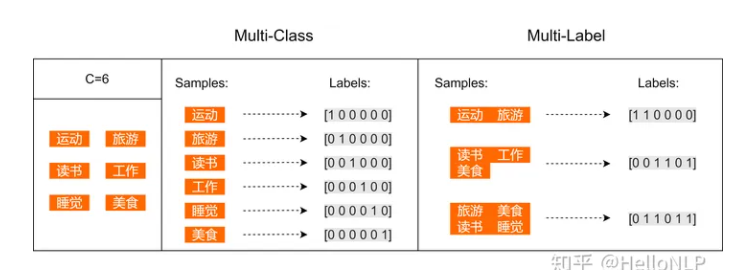

In [7]:
def process_data(examples):
    text = examples['Tweet']
    encoding = tokenizer(text, 
                         padding="max_length",
                         truncation=True,
                         max_length=512)
    
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # {'anger': False,
    #  'anticipation': True,
    #  'disgust': False,
    #  'fear': False,
    #  'joy': False,
    #  'love': False,
    #  'optimism': True,
    #  'pessimism': False,
    #  'sadness': False,
    #  'surprise': False,
    #  'trust': True}
    
    # labels_matrix：(batch_size, num_labels)
    # 填充每个样本的label
    labels_matrix = np.zeros((len(text), len(labels)))
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]
        
    encoding['labels'] = labels_matrix.tolist()
    
    return encoding

In [8]:
encoded_dataset = dataset.map(process_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/13676 [00:00<?, ? examples/s]

Map:   0%|          | 0/1772 [00:00<?, ? examples/s]

Map:   0%|          | 0/6518 [00:00<?, ? examples/s]

In [20]:
type(encoded_dataset['train'])

datasets.arrow_dataset.Dataset

In [9]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [10]:
print(example['labels'])

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]


In [11]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['anticipation', 'optimism', 'trust']

In [12]:
encoded_dataset.set_format("torch")

# 定义模型
### 将problem_type设置为“multi_label_classification”，因为这将确保使用适当的损失函数(即BCEWithLogitsLoss)。我们还确保输出层有len(labels)个输出神经元，并设置id2label和label2id映射。

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_path, 
                                                           problem_type="multi_label_classification",   # 多标签分类
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at D:\code\personal\models\bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at D:\code\p

# 训练模型

In [14]:
batch_size = 8
metric_name = "f1"

In [15]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
 f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,  #用于指定在训练过程中用于选择最优模型的评估指标。当训练完成后，训练脚本会根据这个指定的指标在验证集上的表现来决定保留哪个模型 checkpoint 作为“最佳模型
 #push_to_hub=True,
)

In [16]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
 
# 多标签分类损失函数
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics
    
    
def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # 用于评估每个epoch模型表现
)

In [18]:
trainer.train()

D:\Python\envs\torch\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 100663296 bytes.

In [ ]:
trainer.evaluate()

# 推理

In [ ]:
text = "I'm happy I can finally train a model for multi-label classification"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

In [ ]:
# 转换为具体标签

sigmod = torch.nn.Sigmod()
probs = sigmod(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs > 0.5)] = 1

predicted_labels = [id2labels[idx] for idx, label in enumerate(predictions) if label == 1]
print(predicted_labels)